In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

import pyvene as pv
import torch
import transformers
import os
from dataclasses import dataclass
from typing import List, Optional
import jax
import hydra
import lightning as L
import torch
from hydra.core.config_store import ConfigStore
from lightning.pytorch.loggers import WandbLogger
from omegaconf import MISSING, DictConfig, OmegaConf, open_dict
from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
from task import MetaLearningTask, TaskConfig, FineTuningTask, TuneConfig
import warnings
import numpy as np
from torch.utils.data import DataLoader, Subset
import lightning as L
from typing import *
from dataclasses import dataclass
import torch
from transformers import GPT2LMHeadModel, GPT2Config
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions

from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
from models.gpt import GPT, GPTConfig
from task import MetaLearningTask
from train import TrainConfig
from itertools import product, combinations
from omegaconf.dictconfig import DictConfig
from transformers import PreTrainedModel, PretrainedConfig
import torch.nn as nn
from datasets import load_dataset, Dataset, IterableDataset
import evaluate
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer
from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
import hmmlearn
from sklearn.preprocessing import normalize
from copy import deepcopy
from pympler import asizeof
from hmmlearn.base import _hmmc
import multiprocessing as mp
import ctypes as c
import matplotlib.pyplot as plt
from scipy.stats import entropy
import pickle
from scipy.ndimage import gaussian_filter1d
torch.set_float32_matmul_precision('high')
from hmmlearn.base import _hmmc
import gc
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap
from jax.nn import one_hot

from dynamax.hidden_markov_model import CategoricalHMM
from dynamax.hidden_markov_model.models.categorical_hmm import (
    ParamsCategoricalHMM,
    ParamsStandardHMMTransitions,
    ParamsCategoricalHMMEmissions,
    ParamsStandardHMMInitialState,
)
from jax.scipy.special import logsumexp

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_nor

In [1]:
lora_task = FineTuningTask(
    TuneConfig(
        "i0b1vf6r", LoraConfig(r=16, target_modules="all-linear"), [[1, 0], [2, 1]]
    )
)

NameError: name 'FineTuningTask' is not defined

In [2]:
task = MetaLearningTask("i0b1vf6r")

number of parameters: 18.94M
Loaded dataset : (11288/1000)
Loaded checkpoing : epoch=445,step=10250.ckpt


In [27]:
sum(*[d.indices for d in lora_task.val_data.values()]).shape

(1000,)

In [23]:
list(lora_task.val_data.values())[0].indices + list(lora_task.val_data.values())[1].indices

[np.int64(10240),
 np.int64(4096),
 np.int64(4098),
 np.int64(7168),
 np.int64(7175),
 np.int64(7179),
 np.int64(10255),
 np.int64(7183),
 np.int64(7185),
 np.int64(7201),
 np.int64(4130),
 np.int64(7202),
 np.int64(10290),
 np.int64(4150),
 np.int64(10295),
 np.int64(1089),
 np.int64(10309),
 np.int64(7237),
 np.int64(1096),
 np.int64(7241),
 np.int64(1100),
 np.int64(7245),
 np.int64(10320),
 np.int64(4179),
 np.int64(10324),
 np.int64(1109),
 np.int64(7254),
 np.int64(10328),
 np.int64(7259),
 np.int64(10335),
 np.int64(10340),
 np.int64(10343),
 np.int64(9994),
 np.int64(7277),
 np.int64(7280),
 np.int64(1137),
 np.int64(1136),
 np.int64(1140),
 np.int64(7287),
 np.int64(10360),
 np.int64(4217),
 np.int64(10363),
 np.int64(1150),
 np.int64(1151),
 np.int64(4237),
 np.int64(7316),
 np.int64(10390),
 np.int64(4247),
 np.int64(1175),
 np.int64(1178),
 np.int64(10395),
 np.int64(4254),
 np.int64(7330),
 np.int64(7331),
 np.int64(1192),
 np.int64(1195),
 np.int64(4268),
 np.int64(1196),

In [ ]:
WandbLogger()

In [9]:
trainer = L.Trainer(
    logger=False,
    max_steps=300,
    accelerator='gpu',
    enable_checkpointing=False,
    val_check_interval=50,
    reload_dataloaders_every_n_epochs=1,
    check_val_every_n_epoch=None,
    precision=16
)

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/l/leo.gagnon/latent_control/venv/lib/pyth ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [15]:
trainer.validate(lora_task)

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/l/leo.gagnon/latent_control/venv/lib/pyth ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 128/128 [00:06<00:00, 19.87it/s]
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 488. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
100%|██████████| 128/128 [00:06<00:00, 19.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        seen_tokens        │            0.0            │            0.0            │
│        val_active/        │    0.3188632130622864     │                           │
│      val_active/acc       │    0.2893718481063843     │                           │
│    val_active/ce_loss     │    1.8325622081756592     │                           │
│       val_active/kl       │    0.3188632130622864     │                           │
│    val_active/loglike     │     -364.679931640625     │                           │
│     val_inactive/acc      │                           │    0.2892612814903259     │
│   val_inactive/ce_loss    │                           │    1.8341057300567627     │
│   val_inactive/loglike    │                           │    -364.98699951171875    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'seen_tokens/dataloader_idx_0': 0.0,
  'val_active/acc/dataloader_idx_0': 0.2893718481063843,
  'val_active/loglike/dataloader_idx_0': -364.679931640625,
  'val_active/ce_loss/dataloader_idx_0': 1.8325622081756592,
  'val_active/kl/dataloader_idx_0': 0.3188632130622864,
  'val_active//dataloader_idx_0': 0.3188632130622864},
 {'seen_tokens/dataloader_idx_1': 0.0,
  'val_inactive/acc/dataloader_idx_1': 0.2892612814903259,
  'val_inactive/loglike/dataloader_idx_1': -364.98699951171875,
  'val_inactive/ce_loss/dataloader_idx_1': 1.8341057300567627}]

In [11]:
lora_task.model.enable_adapter_layers()

In [46]:
active_latents = np.unique(lora_task.val_data.indices)
inactive_latents = list(set(range(len(lora_task.full_data))) - set(lora_task.latent_indices))

In [47]:
X_active = lora_task.full_data.__getitems__(np.random.choice(active_latents, 50, replace=False), n_steps=200)
X_inactive = lora_task.full_data.__getitems__(np.random.choice(inactive_latents, 50, replace=False), n_steps=200)

In [48]:
task.cuda();
lls = task.model_loglikelihood(torch.concatenate([X_active[0], X_inactive[0]])).cpu()
task.cpu();

In [49]:
lora_task.cuda();
lls_ = lora_task.model_loglikelihood(torch.concatenate([X_active[0], X_inactive[0]])).cpu()
lora_task.cpu();

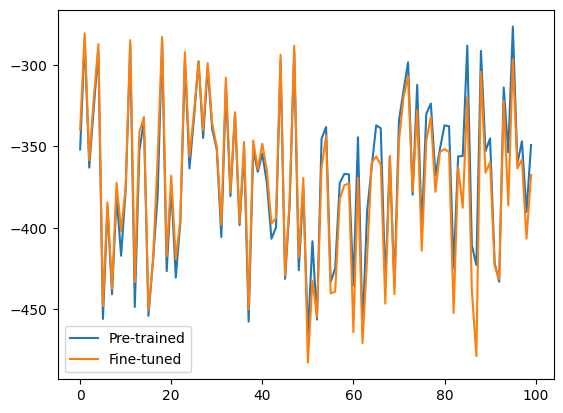

In [50]:
plt.plot(lls.detach(), label='Pre-trained')
plt.plot(lls_.detach(), label='Fine-tuned')
plt.legend()

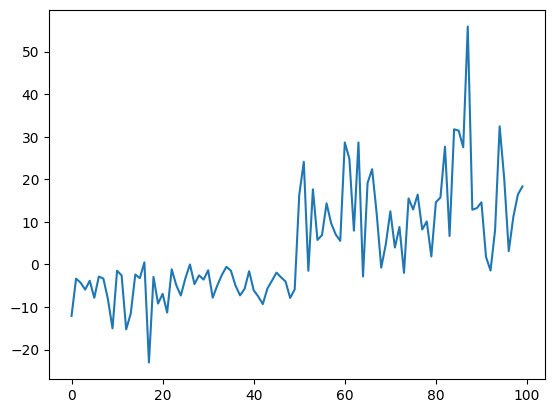

In [51]:
plt.plot(lls.detach() - lls_.detach())

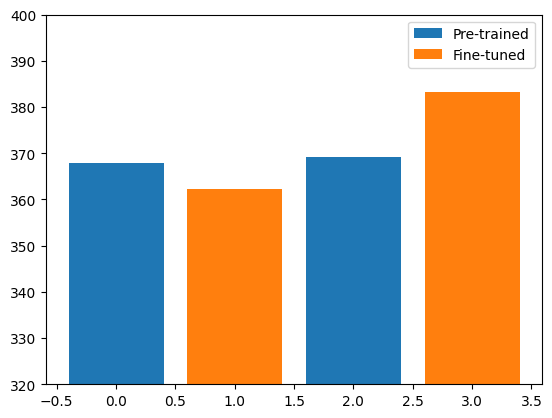

In [52]:
plt.bar(x=[0,2], height=[-a.mean().detach().item() for a in torch.chunk(lls, 2)], label='Pre-trained')
plt.bar(x=[1,3], height=[-a.mean().detach().item() for a in torch.chunk(lls_, 2)], label='Fine-tuned')
plt.ylim(320,400)
plt.legend()

In [56]:
pp_pretrained = task.evaluate_pp(
    128,
    200,
    predicted_envs=np.unique(lora_task.val_data.indices),
    assumed_envs=lora_task.latent_indices,
    seed=0,
)

100%|██████████| 128/128 [00:12<00:00,  9.99it/s]


In [57]:
pp_finetuned = lora_task.evaluate_pp(
    128,
    200,
    predicted_envs=np.unique(lora_task.val_data.indices),
    assumed_envs=lora_task.latent_indices,
    seed=0,
)

100%|██████████| 128/128 [00:14<00:00,  9.03it/s]


In [60]:
pp_base = task.evaluate_pp(
    128, 200, predicted_envs=np.unique(task.val_data.indices), seed=0
)

100%|██████████| 128/128 [00:55<00:00,  2.32it/s]


In [62]:
pp_finetuned_base = lora_task.evaluate_pp(
    128, 200, predicted_envs=np.unique(task.val_data.indices), seed=0
)

100%|██████████| 128/128 [00:48<00:00,  2.65it/s]


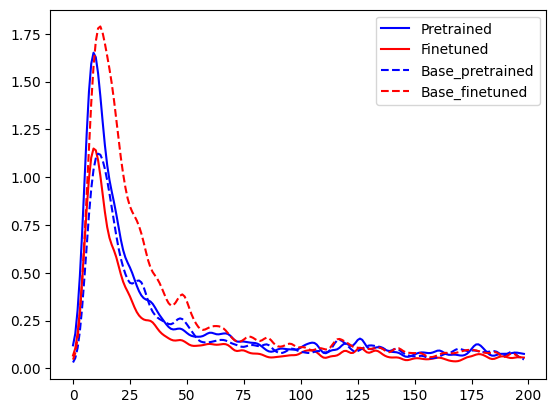

In [64]:
plt.plot(gaussian_filter1d(pp_pretrained['BackwardKL'].mean(0),2), label='Pretrained', linestyle='-', color='blue')
plt.plot(gaussian_filter1d(pp_finetuned['BackwardKL'].mean(0),2), label='Finetuned', linestyle='-', color='red')
plt.plot(gaussian_filter1d(pp_base['BackwardKL'].mean(0),2), label='Base_pretrained', linestyle='--', color='blue')
plt.plot(gaussian_filter1d(pp_finetuned_base['BackwardKL'].mean(0),2), label='Base_finetuned', linestyle='--', color='red')

plt.legend()